In [1]:
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import networkx as nx
import matplotlib.pyplot as plt
import random 

key = jr.PRNGKey(123)

2022-02-12 15:34:18.287712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


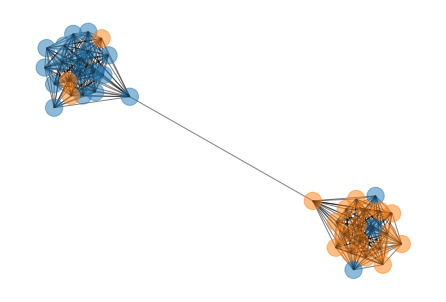

In [2]:
vertex_per_side = 20
p = 0.8

G = nx.barbell_graph(vertex_per_side, 0) 

[G.remove_edge(*i) for i in random.sample(list(G.edges), 30)]
xs = []
ys = []
for idx, (node, subkey) in enumerate(zip(G, jr.split(key, 2*vertex_per_side))):
    if idx < vertex_per_side:
        y = jr.bernoulli(subkey, p).astype(int)
    else:
        y = jr.bernoulli(subkey, 1.-p).astype(int)
    G.nodes[node]['label'] = y
    xs.append(idx)
    ys.append(y)


pos = nx.spring_layout(G, seed=123)  # positions for all nodes
cols = []
for i in ys:
    if i == 0:
        cols.append('tab:blue')
    elif i == 1:
        cols.append('tab:orange')
nx.draw(G, pos, node_color=cols, with_labels=False, alpha=0.5)

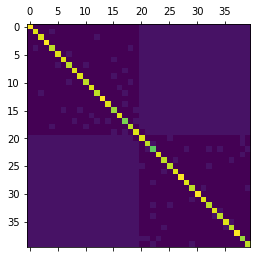

In [3]:
L = nx.laplacian_matrix(G).toarray()
plt.matshow(L)

In [4]:
kernel = gpx.GraphKernel(laplacian=L)

In [5]:
f = gpx.Prior(kernel = kernel)
true_params = f.params
true_params['kernel'] = {'lengthscale': jnp.array(2.3), 'variance': jnp.array(3.2), 'smoothness': jnp.array(6.1)}
rv = f.random_variable(jnp.array(xs).reshape(-1, 1), true_params)

In [6]:
y = rv.sample(seed = key).reshape(-1, 1)
y.shape
D = gpx.Dataset(X = jnp.array(xs).reshape(-1, 1), y=y)

In [7]:
posterior = f * gpx.Gaussian(num_datapoints=y.shape[0])
params, constrainer, unconstrainer = gpx.initialise(posterior)
params = gpx.transform(params, unconstrainer)

In [8]:
from jax import jit
mll = jit(posterior.marginal_log_likelihood(training = D, transformations=constrainer, negative=True))

In [9]:
mll(params)

DeviceArray(51.55720732, dtype=float64)

In [10]:
import optax as ox

opt = ox.adam(learning_rate=0.01)
learned_params = gpx.abstractions.optax_fit(objective = mll, params = params, optax_optim=opt, n_iters=1000)
learned_params = gpx.transform(learned_params, constrainer)

100%|██████████| 1000/1000 [00:20<00:00, 49.56it/s, Objective=-113.8]            


In [11]:
mu = posterior.mean(D, params)(jnp.array(xs).reshape(-1, 1))
jnp.sum(jnp.sqrt(jnp.square(y - mu)))

DeviceArray(10.15658038, dtype=float64)

In [12]:
mu = posterior.mean(D, learned_params)(jnp.array(xs).reshape(-1, 1))
jnp.sum(jnp.sqrt(jnp.square(y - mu)))

DeviceArray(0.31862764, dtype=float64)